In [1]:
import os 
import sys
import time
import datetime
import dateutils
import collections
import itertools
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy as sci
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
# будем использовать спарк
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()
spark

In [4]:
# Посмотрим, как распределяются клиенты по партициям
tmp_dict = {}
for part in tqdm(os.listdir('./raw_data/')):
    if 'part' in part:
        tmp_sdf = spark.read.parquet(os.path.join('./raw_data', part))
        tmp_dict[part.replace('.parquet', '')] = set(
                                                    tmp_sdf
                                                    .select('client')
                                                    .distinct()
                                                    .toPandas()['client']
                                                )
        
for key1, key2, key3 in itertools.combinations(tmp_dict, 3):
    print(key1, key2, key3)
    plt.figure(figsize=(8, 8))
    venn3(
        subsets=[
            tmp_dict[key1],
            tmp_dict[key2],
            tmp_dict[key3]
        ],
        set_labels=[key1, key2, key3]
    );

    venn3_circles(
        subsets=[
            tmp_dict[key1],
            tmp_dict[key2],
            tmp_dict[key3]
        ],
        linewidth=0.5
    );
    plt.show()

Вывод - партиции разбиты по клиенту

In [6]:
clickstream_sdf = spark.read.parquet('./raw_data/parquet/part-*')
print(f"clickstream_sdf: {clickstream_sdf.count():,}")
print(f"Число уникальных клиентов: {clickstream_sdf.select('client').distinct().count():,}")
clickstream_sdf.sample(fraction=10_000 / 120_025_286, withReplacement=False).toPandas().head(20)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49865)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:49865)

* __timestamp__ - дата и время совершения события

* __application_id__- идентификатор приложения

* __client__ - Идентификатор клиента 

* __session_id__ - Идентификатор сессии

* __event_type__ - Тип события

* __event_category__ - Категория события

* __event_name__ - Имя события

* __event_label__ - Дополнительный атрибут события
 
* __device_screen_name__ - Имя экрана на котором произошло событие

* __timezone__ - Часовой пояс

* __device_is_webview__ - Флаг того что страница открыта внутри webview
 
* __page_urlhost__ - Домен страницы

* __page_urlpath_full__ - Путь страницы

* __net_connection_type__ - Тип подключения

* __net_connection_tech__ - Технология подключения

In [7]:
target = pd.read_csv('./raw_data/alfabattle2_abattle_train_target.csv')
target['timestamp'] = pd.to_datetime(target['timestamp'])

In [8]:
print(f"target.shape[0]: {target.shape[0]:,}")
print(f"Число уникальных клиентов: {target['client_pin'].unique().shape[0]:,}")
target.head()

target.shape[0]: 5,065,350
Число уникальных клиентов: 79,268


,session_id,client_pin,timestamp,multi_class_target
0,0000029e72e5fcde6a9f29c3a3ed198f,7cf9221322a0e2fdefb1b998b8f2ab29,2020-06-15 14:01:12,main_screen
1,00063dffa47b0fe5556b2b9e8beddb6a,5f16c0ab27a806fd08db3122921adf3a,2020-03-21 12:59:34,invest
2,0007857f36d268ec46fcb7305538a1c7,ec868fc2b388293cf10e18ee9518d72f,2020-01-24 18:18:55,statement
3,000a7f25fc3609cdfda54c5f059aab00,91f55a33d7502c1a1fa5da7ff2f7b648,2020-03-15 19:50:23,main_screen
4,000b746d6616669663feaa1474ac97f1,3ef1020bda95ce7836d2680fa553ecb7,2020-02-20 07:56:58,main_screen


In [9]:
target_time_df = pd.read_csv('./raw_data/alfabattle2_prediction_session_timestamp.csv')
target_time_df['timestamp'] = pd.to_datetime(target_time_df['timestamp'])
print(f"{target_time_df.shape[0]:,}")
target_time_df.head()

79,268


,client_pin,timestamp
0,f0c674b2bb4dc64be607029271d706ec,2020-08-01 00:00:53
1,90725b54ce77576883813d87749df6bd,2020-08-01 00:02:57
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,2020-08-01 00:03:14
3,831bf4c0ecccc55e536b8cfb9153d672,2020-08-01 00:04:44
4,3f1a5a1c492ce877af833113e59c5797,2020-08-01 00:06:40


In [10]:
sample_sub_df = pd.read_csv('./raw_data/alfabattle2_abattle_sample_prediction.csv')

In [11]:
print(f"{sample_sub_df.shape[0]:,}")
sample_sub_df.head()

79,268


,client_pin,prediction
0,f0c674b2bb4dc64be607029271d706ec,credit_info
1,90725b54ce77576883813d87749df6bd,credit_info
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,own_transfer
3,831bf4c0ecccc55e536b8cfb9153d672,statement
4,3f1a5a1c492ce877af833113e59c5797,invest


### EDA

In [12]:
(
    clickstream_sdf
    .agg(
        F.min(F.col('timestamp')).alias('min_timestamp'),
        F.max(F.col('timestamp')).alias('min_timestamp')
    )
    .show()
)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:61953)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:61953)

In [25]:
# Доля Нанов в фичах кликстрима
(
    clickstream_sdf
    .agg(
        *[F.mean(F.when(F.isnull(F.col(col)), F.lit(1)).otherwise(F.lit(0))).alias(col) for col in 
              clickstream_sdf.columns]
    )
    .toPandas().T
)

,0
timestamp,0.000000
application_id,0.000000
client,0.000000
session_id,0.000000
event_type,0.000000
event_category,0.457430
event_name,0.464170
event_label,0.859631
device_screen_name,0.226116
timezone,0.000000


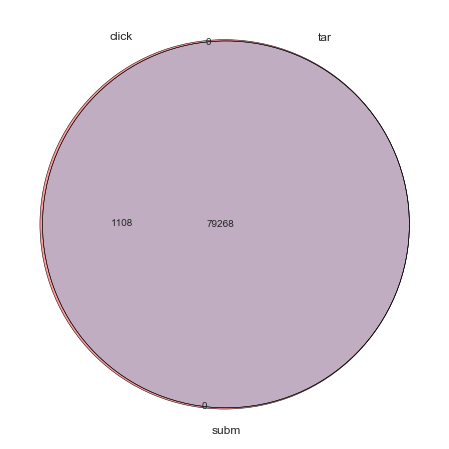

In [28]:
# Пересечение клиентов в кликстриме, таргетах и сэмпл сабмите
clickstream_clients_set = set(
    clickstream_sdf.select('client').distinct().toPandas()['client']
)

target_clients_set = set(
    target['client_pin']
)

sabm_clients_set = set(
    sample_sub_df['client_pin']
)

venn3(
    subsets=[
        clickstream_clients_set,
        target_clients_set,
        sabm_clients_set
    ],
    set_labels=['click', 'tar', 'subm']
);

venn3_circles(
    subsets=[
        clickstream_clients_set,
        target_clients_set,
        sabm_clients_set
    ],
    linewidth=0.5
);

В кликстриме на 1108 уникальных клиентов больше чем в таргете и сабмите

In [14]:
clickstream_sdf.columns

['timestamp',
 'application_id',
 'client',
 'session_id',
 'event_type',
 'event_category',
 'event_name',
 'event_label',
 'device_screen_name',
 'timezone',
 'device_is_webview',
 'page_urlhost',
 'page_urlpath_full',
 'net_connection_type',
 'net_connection_tech']

In [26]:
tmp_df = (
    clickstream_sdf
    .filter(
        (F.col('client') == '7cf9221322a0e2fdefb1b998b8f2ab29')
    )
    .orderBy(F.col('timestamp').asc())
#     .select(
#         F.col('client').alias('pin'),
#         F.col('timestamp').alias('time'),
#         F.col('session_id').alias('session'),
#         F.col('event_label').alias('labl')
#     )
    .toPandas()
)

tmp_df

,timestamp,application_id,client,session_id,event_type,event_category,event_name,event_label,device_screen_name,timezone,device_is_webview,page_urlhost,page_urlpath_full,net_connection_type,net_connection_tech
0,2020-01-01 14:22:34.180,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,sv,None,None,None,SignInActivity,Europe/Moscow,True,None,None,mobile,LTE
1,2020-01-01 14:22:40.700,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,sv,None,None,None,MainListFragment,Europe/Moscow,True,None,None,mobile,LTE
2,2020-01-01 14:22:46.124,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,Bottom Navigation,Click > Statements screen Tab,None,Main list,Europe/Moscow,True,None,None,mobile,LTE
3,2020-01-01 14:22:46.252,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,sv,None,None,None,StatementFragment,Europe/Moscow,True,None,None,mobile,LTE
4,2020-01-01 14:22:50.078,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,SingleStatement,load statement bonus,7a4e59a5d9e3bf6484ec3ca5e9f7e277,Single Statement,Europe/Moscow,True,None,None,mobile,LTE
5,2020-01-01 14:22:50.085,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,SingleStatement,load statement bonus,7a4e59a5d9e3bf6484ec3ca5e9f7e277,Single Statement,Europe/Moscow,True,None,None,mobile,LTE
6,2020-01-01 14:23:15.467,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,SingleStatement,Force refresh,None,Single Statement,Europe/Moscow,True,None,None,mobile,LTE
7,2020-01-01 14:23:16.857,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,SingleStatement,load statement bonus,7a4e59a5d9e3bf6484ec3ca5e9f7e277,Single Statement,Europe/Moscow,True,None,None,mobile,LTE
8,2020-01-01 14:23:17.656,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,7091b2e1349627289f1226e7ae0cf791,se,Bottom Navigation,Click > Main list Tab,None,Statements screen,Europe/Moscow,True,None,None,mobile,LTE
9,2020-01-01 17:55:07.729,mobile,7cf9221322a0e2fdefb1b998b8f2ab29,041dfc0f1d734894727ca11f56714ff8,sv,None,None,None,SignInActivity,Europe/Moscow,True,None,None,mobile,LTE


In [44]:
target_sdf = spark.read.csv('./raw_data/alfabattle2_abattle_train_target.csv', header=True)

In [49]:
clickstream_sdf.select(F.col('timestamp').cast('timestamp')).show()

+--------------------+
|           timestamp|
+--------------------+
|2020-02-02 17:24:...|
|2020-05-25 02:21:...|
|2020-04-25 19:55:...|
| 2020-01-11 14:37:27|
|2020-01-31 11:36:...|
|2020-01-26 19:59:...|
| 2020-04-10 23:08:18|
|2020-01-20 18:00:...|
|2020-08-29 18:28:...|
|2020-03-02 10:49:...|
|2020-06-25 17:48:...|
|2020-02-27 15:11:...|
|2020-01-31 11:10:...|
|2020-01-31 11:37:...|
|2020-01-26 20:00:...|
|2020-01-23 20:35:...|
|2020-02-04 18:31:...|
|2020-02-04 18:33:...|
|2020-02-28 19:50:...|
|2020-02-28 19:50:...|
+--------------------+
only showing top 20 rows



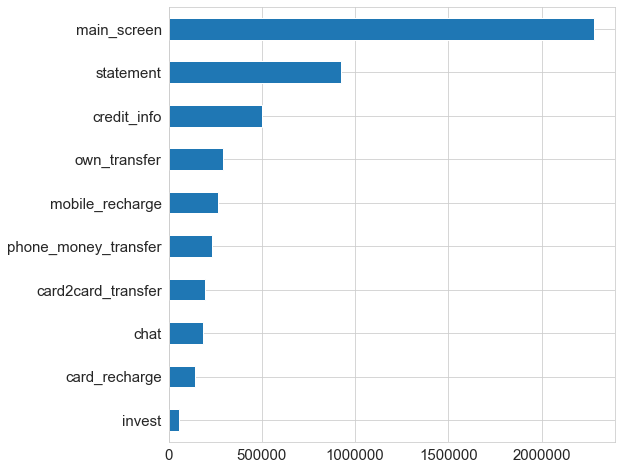

In [14]:
target.multi_class_target.value_counts(ascending=True).plot(kind='barh', fontsize=15);

In [60]:
%%time
tmp_sdf = (
    target_sdf
    .select('client_pin', F.col('timestamp').cast('timestamp'))
    .join(
        clickstream_sdf
        .select(F.col('client').alias('client_pin'), F.col('timestamp').cast('timestamp'))
        ,
        on=['client_pin', 'timestamp'],
        how='inner'
    )
)

tmp_sdf.count()

CPU times: user 32 ms, sys: 24.1 ms, total: 56.1 ms
Wall time: 3min 35s


32

In [63]:
clickstream_sdf.count()

120025286

### Features

In [72]:
(
    clickstream_sdf
    .filter(
        (F.col('client').contains('fb363113d6fa511ba')) &
        (F.col('timestamp') == datetime.datetime(2020, 1, 10, 18, 58, 45))
    )
    .toPandas()
)

,timestamp,application_id,client,session_id,event_type,event_category,event_name,event_label,device_screen_name,timezone,device_is_webview,page_urlhost,page_urlpath_full,net_connection_type,net_connection_tech
0,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
1,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
2,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
3,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
4,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
5,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
6,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
7,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
8,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE
9,2020-01-10 18:58:45,mobile,fb363113d6fa511ba7d67873e2f7afa0,8472bdb2679f51090ec063034250cc8d,se,Chat,Request History Result > Success,None,Chat,Europe/Samara,None,None,None,mobile,LTE


In [267]:
%%time
# Делаем для каждого действия клиента его номер, начиная от конца
target['rank'] = (
    target
    .groupby(['client_pin'])
    ['timestamp']
    .rank(method="first", ascending=False)
)

# Проверяем, что ранг посчитали правильно:
# pin'ы для проверки
# 674595ee5acb8c2ede30dadfa722ba9d 
# 25074c2bd77b64c40a4c6a623a748724    
# e17a88a65bca752fbb13c2418ba09d18 
# f8ae0cf709bae7760888c2a1497529a1

target.loc[
    (target['client_pin'] == '674595ee5acb8c2ede30dadfa722ba9d')
].sort_values(by=['timestamp'], ascending=True).tail()

CPU times: user 3.72 s, sys: 128 ms, total: 3.85 s
Wall time: 3.85 s


,session_id,client_pin,timestamp,multi_class_target,rank
259124,cd975992021f1f9951255c7775c76ca5,674595ee5acb8c2ede30dadfa722ba9d,2020-07-30 13:26:17,main_screen,5.0
1155293,ff470d57211a67c86126381a77f3b9aa,674595ee5acb8c2ede30dadfa722ba9d,2020-09-25 07:01:48,card_recharge,4.0
1745389,23d524b52f49c107f3b4ecc9123ce9fe,674595ee5acb8c2ede30dadfa722ba9d,2020-09-25 16:12:35,main_screen,3.0
3425470,11f50a971370b86ca8226dbd2698125a,674595ee5acb8c2ede30dadfa722ba9d,2020-09-25 18:04:38,main_screen,2.0
2348336,e50b00171af117fd20216801f5835663,674595ee5acb8c2ede30dadfa722ba9d,2020-09-25 21:02:30,main_screen,1.0


In [65]:
(
    clickstream_sdf
    .groupBy('client', 'timestamp')
    .count()
    .orderBy(F.col('count').desc())
    .show()
)

+--------------------+-------------------+-----+
|              client|          timestamp|count|
+--------------------+-------------------+-----+
|fb363113d6fa511ba...|2020-01-10 18:58:45|   32|
|39a4c7a30aca52517...|2020-01-07 12:39:41|   29|
|d28806a814a5cce63...|2020-01-08 17:29:26|   28|
|d28806a814a5cce63...|2020-01-10 09:25:47|   27|
|d607b07242003eb72...|2020-01-08 15:41:34|   25|
|4bae833abd4a1696b...|2020-01-09 13:53:33|   23|
|73f5394f7ab5a7f6c...|2020-01-10 10:11:30|   23|
|73f5394f7ab5a7f6c...|2020-01-09 14:16:40|   22|
|503672d41d69e313b...|2020-01-08 21:50:31|   21|
|97b48ec157269e5ba...|2020-01-08 09:07:17|   21|
|3e4efc04461d2ccb7...|2020-01-09 03:13:07|   21|
|734c89e41e39dbabf...|2020-01-09 11:59:17|   21|
|60906c96a209f6fb1...|2020-01-09 12:21:30|   21|
|cb7d142436f729238...|2020-01-08 11:30:49|   20|
|3e4efc04461d2ccb7...|2020-01-09 03:07:48|   20|
|d28806a814a5cce63...|2020-01-09 13:00:46|   20|
|73f5394f7ab5a7f6c...|2020-01-09 14:56:20|   19|
|1e288e36927cfede0..

In [12]:
target_time_df

,client_pin,timestamp
0,f0c674b2bb4dc64be607029271d706ec,2020-08-01 00:00:53
1,90725b54ce77576883813d87749df6bd,2020-08-01 00:02:57
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,2020-08-01 00:03:14
3,831bf4c0ecccc55e536b8cfb9153d672,2020-08-01 00:04:44
4,3f1a5a1c492ce877af833113e59c5797,2020-08-01 00:06:40
...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,2020-09-30 23:41:47
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,2020-09-30 23:43:25
79265,94bcc852dd7f806f6c733056d1b0be7b,2020-09-30 23:50:37
79266,2061f779928217eea2878fd3b605fafd,2020-09-30 23:53:03


In [268]:
# Собираем датафрейм, где для каждого клиента по столбцам будут хранится даты его d последних действий и 
# сами эти действия
d = 50
Xy_df = pd.DataFrame(target['client_pin'].unique(), columns=['client_pin'])
for i in tqdm(range(1, d+1)):
    tmp_df = (
        target
        .loc[(target['rank'] == i), ['client_pin', 'timestamp', 'multi_class_target']]
        .rename(columns={"timestamp": f'timestamp_{i}', 'multi_class_target': f'action_{i}'})
    )
    Xy_df = Xy_df.merge(tmp_df, on=['client_pin'], how='left')
Xy_df = Xy_df.merge(target_time_df.rename(columns={'timestamp': 'timestamp_target'}), on=['client_pin'], how='left')

# Xy_df.to_csv('./tmp/Xy_df.csv', index=False)

In [269]:
Xy_df

,client_pin,timestamp_1,action_1,timestamp_2,action_2,timestamp_3,action_3,timestamp_4,action_4,timestamp_5,...,action_46,timestamp_47,action_47,timestamp_48,action_48,timestamp_49,action_49,timestamp_50,action_50,timestamp_target
0,7cf9221322a0e2fdefb1b998b8f2ab29,2020-07-26 13:56:19,main_screen,2020-07-25 15:52:04,main_screen,2020-07-25 14:56:30,phone_money_transfer,2020-07-22 23:27:51,phone_money_transfer,2020-07-21 02:56:50,...,card2card_transfer,2020-04-18 17:06:30,phone_money_transfer,2020-04-15 18:49:46,statement,2020-04-13 17:27:38,statement,2020-04-13 16:58:49,card2card_transfer,2020-08-02 18:37:47
1,5f16c0ab27a806fd08db3122921adf3a,2020-08-17 15:23:42,main_screen,2020-08-17 09:11:36,main_screen,2020-08-16 09:19:24,statement,2020-08-06 09:06:39,statement,2020-08-01 18:33:16,...,statement,2020-05-13 17:12:19,main_screen,2020-05-13 14:30:44,main_screen,2020-05-13 12:07:29,main_screen,2020-05-12 13:01:52,statement,2020-08-17 21:12:20
2,ec868fc2b388293cf10e18ee9518d72f,2020-09-15 16:15:48,statement,2020-09-12 20:41:29,statement,2020-09-12 08:05:25,mobile_recharge,2020-09-11 15:57:03,mobile_recharge,2020-09-10 08:34:20,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-09-16 11:22:41
3,91f55a33d7502c1a1fa5da7ff2f7b648,2020-07-29 22:38:46,statement,2020-07-27 19:07:35,statement,2020-07-27 09:59:31,main_screen,2020-07-26 07:30:18,main_screen,2020-07-24 17:22:57,...,statement,2020-06-29 09:11:53,statement,2020-06-27 22:26:20,statement,2020-06-26 22:26:17,statement,2020-06-26 11:12:55,statement,2020-08-14 09:44:27
4,3ef1020bda95ce7836d2680fa553ecb7,2020-07-06 23:15:30,main_screen,2020-06-30 06:23:23,main_screen,2020-06-12 22:33:09,card_recharge,2020-06-12 10:56:44,statement,2020-04-25 08:33:54,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-08-16 08:42:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79263,10523a04b3b0d6a56fa4fc174341068b,2020-06-28 05:26:21,chat,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-08-05 10:16:29
79264,2c1534e4670e67792f743cda635854cd,2020-04-05 15:51:01,card_recharge,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-08-26 23:39:11
79265,4464d63f254caf6ed2854058e4ad532f,2020-02-05 10:39:31,main_screen,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-08-19 18:22:09
79266,dfe8e4bec5013949accb3a165afb2d44,2020-08-21 20:21:49,card2card_transfer,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2020-08-21 21:55:22


In [17]:
(
    target
    .groupby(['client_pin'])
    ['timestamp']
    .count()
    .sort_values(ascending=False)
)

client_pin
674595ee5acb8c2ede30dadfa722ba9d    1646
25074c2bd77b64c40a4c6a623a748724    1626
e17a88a65bca752fbb13c2418ba09d18    1550
bdfb2a491cb1a146358319b6955d7308    1535
bb0a6c5a08ae8581854386e8421a3773    1487
                                    ... 
aac01b44d30aaf65c97cde1419d07ac2       1
d491c81db03c07fcae5977683cb94d73       1
d490675964f52574b149cf24cd657017       1
7b06e13bd71901a29b27ca7e15dd10c3       1
73cd734eea37608988df33b641c7638d       1
Name: timestamp, Length: 79268, dtype: int64

In [18]:
# Xy_df = pd.read_csv('./tmp/Xy_df.csv')
for col in tqdm(Xy_df.columns):
    if 'timestamp' in col:
        Xy_df[col] = pd.to_datetime(Xy_df[col])

In [19]:
# Расстояние до целевого действия (количество секунд)
from typing import List

def compute_time_delta(target_time_col: pd.Series, time_cols_df: pd.DataFrame) -> pd.DataFrame:
    
    tmp_df = pd.DataFrame()
    for col in tqdm(time_cols_df.columns):
        tmp_series = target_time_col.reset_index(drop=True) - time_cols_df[col].reset_index(drop=True)
        tmp_series = tmp_series.apply(lambda x: x.days*24*60*60 + x.seconds)
        tmp_df[f'target_col_time-{col}'] = tmp_series
    return tmp_df

In [20]:
tmp_df = compute_time_delta(
    target_time_col=Xy_df['timestamp_1'], 
    time_cols_df=Xy_df[[f'timestamp_{i}' for i in range(2, 10+1)]]
)

Xy_df = pd.concat([Xy_df.reset_index(drop=True), tmp_df], axis=1)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49865)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49865)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Trac

In [190]:
Xy_df

,client_pin,timestamp_1,action_1,timestamp_2,action_2,timestamp_3,action_3,timestamp_4,action_4,timestamp_5,...,timestamp_target,target_col_time-timestamp_2,target_col_time-timestamp_3,target_col_time-timestamp_4,target_col_time-timestamp_5,target_col_time-timestamp_6,target_col_time-timestamp_7,target_col_time-timestamp_8,target_col_time-timestamp_9,target_col_time-timestamp_10
0,7cf9221322a0e2fdefb1b998b8f2ab29,2020-07-26 13:56:19,main_screen,2020-07-25 15:52:04,main_screen,2020-07-25 14:56:30,phone_money_transfer,2020-07-22 23:27:51,phone_money_transfer,2020-07-21 02:56:50,...,2020-08-02 18:37:47,79455.0,82789.0,311308.0,471569.0,768311.0,1376073.0,1466519.0,1469959.0,1471744.0
1,5f16c0ab27a806fd08db3122921adf3a,2020-08-17 15:23:42,main_screen,2020-08-17 09:11:36,main_screen,2020-08-16 09:19:24,statement,2020-08-06 09:06:39,statement,2020-08-01 18:33:16,...,2020-08-17 21:12:20,22326.0,108258.0,973023.0,1371026.0,1716315.0,2566560.0,2837616.0,2860211.0,2922332.0
2,ec868fc2b388293cf10e18ee9518d72f,2020-09-15 16:15:48,statement,2020-09-12 20:41:29,statement,2020-09-12 08:05:25,mobile_recharge,2020-09-11 15:57:03,mobile_recharge,2020-09-10 08:34:20,...,2020-09-16 11:22:41,243259.0,288623.0,346725.0,459688.0,620157.0,1759208.0,2097436.0,2507877.0,2513243.0
3,91f55a33d7502c1a1fa5da7ff2f7b648,2020-07-29 22:38:46,statement,2020-07-27 19:07:35,statement,2020-07-27 09:59:31,main_screen,2020-07-26 07:30:18,main_screen,2020-07-24 17:22:57,...,2020-08-14 09:44:27,185471.0,218355.0,313708.0,450949.0,457635.0,533248.0,538996.0,541742.0,549831.0
4,3ef1020bda95ce7836d2680fa553ecb7,2020-07-06 23:15:30,main_screen,2020-06-30 06:23:23,main_screen,2020-06-12 22:33:09,card_recharge,2020-06-12 10:56:44,statement,2020-04-25 08:33:54,...,2020-08-16 08:42:10,579127.0,2076141.0,2117926.0,6273696.0,7910545.0,8151576.0,8595363.0,9696408.0,11454177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79263,10523a04b3b0d6a56fa4fc174341068b,2020-06-28 05:26:21,chat,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,2020-08-05 10:16:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79264,2c1534e4670e67792f743cda635854cd,2020-04-05 15:51:01,card_recharge,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,2020-08-26 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79265,4464d63f254caf6ed2854058e4ad532f,2020-02-05 10:39:31,main_screen,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,2020-08-19 18:22:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79266,dfe8e4bec5013949accb3a165afb2d44,2020-08-21 20:21:49,card2card_transfer,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,2020-08-21 21:55:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разбиение на обучение и контроль

Можно попробовать 2 разбиения:
* Разбить клиентов на обучение и контроль, при это со всей известной историей
* Всех клиентов до определённого действия (по последнего действия) отнести в обечения, и оставшиеся действия всех клиентов отнести в контроль

1)

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
Xy_tr, Xy_te = train_test_split(Xy_df, test_size=0.37, shuffle=True, random_state=42)
print(f'Xy_tr.shape[0]: {Xy_tr.shape[0]:,}, Xy_te.shape[0]: {Xy_te.shape[0]:,}')

Xy_tr.shape[0]: 49,938, Xy_te.shape[0]: 29,330


In [224]:
# Вспомогательная функция, для рисования графиков
def sort_by_other_array(which_sort_array: np.array, by_which_array: np.array) -> np.array:
    
    assert np.unique(by_which_array).shape[0] == by_which_array.shape[0], \
    'в by_which_array должны быть уникальные значения!'
    
    resulting_array = []
    for val in by_which_array:
        resulting_array.append(
            np.where(which_sort_array == val)[0][0]
        )
    return np.array(resulting_array)

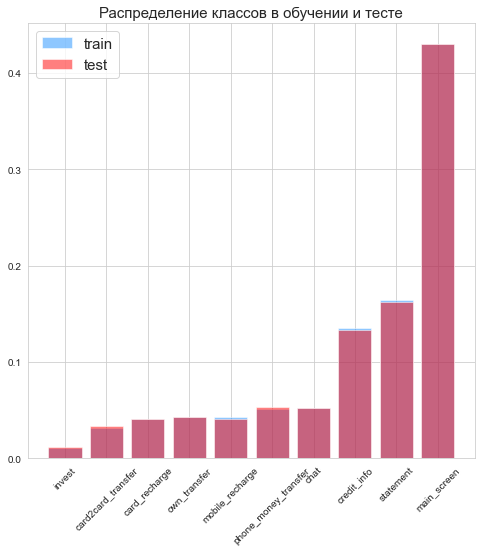

In [225]:
tar_tr, count_tr = np.unique(Xy_tr['action_1'], return_counts=True)
tar_te, count_te = np.unique(Xy_te['action_1'], return_counts=True)

tar_tr = tar_tr[np.argsort(count_tr)]
count_tr = np.sort(count_tr)
# сортируем значения в тесте так же, как сортировали в обучении
count_te = count_te[sort_by_other_array(which_sort_array=tar_te, by_which_array=tar_tr)]

plt.title(f'Распределение классов в обучении и тесте', fontsize=15)
plt.bar(tar_tr, count_tr/sum(count_tr), color='dodgerblue', alpha=0.5, label='train');
plt.bar(tar_tr, count_te/sum(count_te), color='red', alpha=0.5, label='test');
plt.legend(fontsize=15);
plt.tick_params(axis='x', rotation=45)

2)

In [26]:
Xy_tr = Xy_df[['client_pin'] + [f'timestamp_{i}']]

In [32]:
Xy_tr

,client_pin,timestamp_1,action_1,timestamp_2,action_2,timestamp_3,action_3,timestamp_4,action_4,timestamp_5,...,timestamp_target,target_col_time-timestamp_2,target_col_time-timestamp_3,target_col_time-timestamp_4,target_col_time-timestamp_5,target_col_time-timestamp_6,target_col_time-timestamp_7,target_col_time-timestamp_8,target_col_time-timestamp_9,target_col_time-timestamp_10
13024,7728d831aac48c449e828d4900e68132,2020-08-12 20:26:22,chat,2020-07-31 18:10:00,main_screen,2020-07-22 10:07:36,main_screen,2020-07-20 04:05:17,mobile_recharge,2020-07-18 13:39:12,...,2020-08-15 16:24:41,1044982.0,1851526.0,2046065.0,2184430.0,2624091.0,2902476.0,5057539.0,5198310.0,5634985.0
27530,303a139078a837db9de945100bca2225,2020-08-12 16:48:45,main_screen,2020-08-05 06:19:37,credit_info,2020-08-03 07:22:28,credit_info,2020-08-02 10:25:11,card_recharge,2020-08-01 13:15:30,...,2020-08-13 16:00:58,642548.0,811577.0,887014.0,963195.0,1225492.0,2775536.0,4580959.0,5294527.0,6597605.0
60195,7107e9683265dfe6b7e1709789deda03,2020-07-28 23:36:22,phone_money_transfer,2020-07-23 20:38:02,phone_money_transfer,2020-07-20 22:46:00,statement,2020-07-15 17:50:22,main_screen,2020-07-13 21:48:03,...,2020-09-07 22:07:50,442700.0,694222.0,1143960.0,1302499.0,1913111.0,2117452.0,2440174.0,2443617.0,2506580.0
5665,232a3522e7299c96d635d74e6de9cf80,2020-08-13 07:35:43,statement,2020-08-11 15:11:21,statement,2020-08-04 18:35:31,statement,2020-08-02 03:17:08,statement,2020-08-01 03:52:56,...,2020-08-13 08:19:37,145462.0,738012.0,965915.0,1050167.0,1356394.0,1644696.0,2148627.0,2469443.0,2662081.0
48950,b71a3a92a94a68fe4e9d2ff51507ae74,2020-09-25 14:53:36,main_screen,2020-09-25 13:09:15,main_screen,2020-09-25 09:49:42,main_screen,2020-09-24 22:24:39,main_screen,2020-09-24 12:54:21,...,2020-09-25 15:37:59,6261.0,18234.0,59337.0,93555.0,98752.0,168940.0,188335.0,257864.0,316504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0093f0572f1adafee45eb54ea12637f2,2020-08-20 14:05:47,main_screen,2020-08-19 20:58:55,main_screen,2020-08-19 02:11:11,statement,2020-08-17 22:08:18,main_screen,2020-08-17 14:47:47,...,2020-08-21 15:37:46,61612.0,129276.0,230249.0,256680.0,331395.0,493552.0,599352.0,604051.0,607333.0
54886,e6546ab4539ad65f3fda40c23de3e2df,2020-06-01 14:20:00,credit_info,2020-05-30 23:58:06,credit_info,2020-05-24 10:05:45,main_screen,2020-05-21 10:00:32,main_screen,2020-05-20 18:53:43,...,2020-08-09 22:13:09,138114.0,706455.0,965968.0,1020377.0,1039840.0,1176671.0,1799742.0,6406372.0,6441344.0
76820,6d33e7e1bd6e4d738c5000bee6cd3844,2020-09-03 22:30:41,chat,2020-08-28 22:00:39,invest,NaT,NaN,NaT,NaN,NaT,...,2020-09-04 16:29:43,520202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,921c3ebc613e06c4a8b42a59b110cb33,2020-08-20 11:23:32,main_screen,2020-08-20 10:58:46,main_screen,2020-08-19 17:06:17,main_screen,2020-08-19 12:16:34,statement,2020-08-11 11:22:42,...,2020-08-20 17:37:46,1486.0,65835.0,83218.0,777650.0,854408.0,856358.0,1821178.0,1959195.0,1964180.0


### Models

In [226]:
from sklearn.metrics import f1_score

In [265]:
from catboost import CatBoostClassifier

from hyperopt import hp
import numpy as np
from sklearn.metrics import f1_score


import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [228]:
N = 10
cat_features = [f'action_{i}' for i in range(2, N+1)]
feature_columns = [f'target_col_time-timestamp_{i}' for i in range(2, N+1)] \
                  + cat_features
target_col = 'action_1'

In [187]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(100, 400, 100))
}
xgb_fit_params = {
    'eval_metric': 'f1_score',
    'early_stopping_rounds': 10,
    'verbose': True
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: f1_score(y, y_pred)


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(100, 400, 100))
}
lgb_fit_params = {
    'eval_metric': 'f1_score',
    'early_stopping_rounds': 10,
    'verbose': True
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: f1_score(y, pred)


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      hp.choice('n_estimators', np.arange(100, 400, 100)),
    'eval_metric':       'f1_score',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': True
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: f1_score(y, pred)


In [188]:
class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [ ]:
ctb.CatBoostClassifier()

### My part

In [250]:
import warnings
warnings.filterwarnings("ignore")

In [251]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import f1_score

In [262]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)}

In [263]:
# Classifier:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha'],min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree']))
    evaluation = [( Xy_tr[feature_columns], Xy_tr[target_col]), ( Xy_te[feature_columns], Xy_te[target_col])]
    
    model.fit(Xy_tr[feature_columns], Xy_tr[target_col],
            eval_set=evaluation, eval_metric="f1_score",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(Xy_te[feature_columns])
    f1_score = f1_score(Xy_te[target_col], pred)
    print ("SCORE:", f1_score)
    #change the metric if you like
    return {'loss': -f1_score, 'status': STATUS_OK, 'model': model}

In [264]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: 'n_estimators'


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


KeyError: 'n_estimators'

In [195]:
# Заполняем наны в кэт фичах -----------------------------------------------------------------------------------------
Xy_tr[cat_features] = Xy_tr[cat_features].fillna(method='bfill', axis=1).fillna(value='nan_category')
Xy_te[cat_features] = Xy_te[cat_features].fillna(method='bfill', axis=1).fillna(value='nan_category')
#---------------------------------------------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [199]:
obj = HPOpt(Xy_tr[feature_columns], Xy_te[feature_columns], Xy_tr[target_col], Xy_te[target_col])

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields action_2, action_3, action_4, action_5, action_6, action_7, action_8, action_9, action_10


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: action_2, action_3, action_4, action_5, action_6, action_7, action_8, action_9, action_10


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Bad value for num_feature[non_default_doc_idx=0,feature_idx=9]="main_screen": Cannot convert 'b'main_screen'' to float


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


In [271]:
model = CatBoostClassifier(
    cat_features=cat_features,learning_rate=0.1
    
)
#model = xgb.XGBClassifier()

# Заполняем наны в кэт фичах -----------------------------------------------------------------------------------------
Xy_tr[cat_features] = Xy_tr[cat_features].fillna(method='bfill', axis=1).fillna(value='nan_category')
Xy_te[cat_features] = Xy_te[cat_features].fillna(method='bfill', axis=1).fillna(value='nan_category')
#---------------------------------------------------------------------------------------------------------------------

#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}


#randomized_search_result = model.randomized_search(grid,
#                                                   X=Xy_tr[feature_columns],
#                                                   y=Xy_tr[target_col],
#                                                   plot=True)
model.fit(Xy_tr[feature_columns],Xy_tr[target_col])



0:	learn: 2.1006902	total: 295ms	remaining: 4m 54s
1:	learn: 1.9819212	total: 530ms	remaining: 4m 24s
2:	learn: 1.9006971	total: 713ms	remaining: 3m 56s
3:	learn: 1.8386901	total: 943ms	remaining: 3m 54s
4:	learn: 1.7861899	total: 1.26s	remaining: 4m 10s
5:	learn: 1.7390169	total: 1.55s	remaining: 4m 16s
6:	learn: 1.6997255	total: 1.88s	remaining: 4m 26s
7:	learn: 1.6692808	total: 2.23s	remaining: 4m 36s
8:	learn: 1.6431930	total: 2.56s	remaining: 4m 42s
9:	learn: 1.6161879	total: 2.89s	remaining: 4m 46s
10:	learn: 1.5945834	total: 3.17s	remaining: 4m 44s
11:	learn: 1.5765839	total: 3.46s	remaining: 4m 44s
12:	learn: 1.5609801	total: 3.71s	remaining: 4m 41s
13:	learn: 1.5479475	total: 3.99s	remaining: 4m 41s
14:	learn: 1.5360038	total: 4.29s	remaining: 4m 41s
15:	learn: 1.5241118	total: 4.59s	remaining: 4m 42s
16:	learn: 1.5132982	total: 4.9s	remaining: 4m 43s
17:	learn: 1.5020389	total: 5.19s	remaining: 4m 43s
18:	learn: 1.4946377	total: 5.49s	remaining: 4m 43s
19:	learn: 1.4874712	to

158:	learn: 1.3129476	total: 1m 2s	remaining: 5m 28s
159:	learn: 1.3124569	total: 1m 2s	remaining: 5m 28s
160:	learn: 1.3121529	total: 1m 2s	remaining: 5m 28s
161:	learn: 1.3119921	total: 1m 3s	remaining: 5m 27s
162:	learn: 1.3117706	total: 1m 3s	remaining: 5m 27s
163:	learn: 1.3113935	total: 1m 4s	remaining: 5m 27s
164:	learn: 1.3112497	total: 1m 4s	remaining: 5m 27s
165:	learn: 1.3108270	total: 1m 5s	remaining: 5m 27s
166:	learn: 1.3104982	total: 1m 5s	remaining: 5m 26s
167:	learn: 1.3101734	total: 1m 5s	remaining: 5m 26s
168:	learn: 1.3098469	total: 1m 6s	remaining: 5m 26s
169:	learn: 1.3096787	total: 1m 6s	remaining: 5m 26s
170:	learn: 1.3093242	total: 1m 7s	remaining: 5m 25s
171:	learn: 1.3089100	total: 1m 7s	remaining: 5m 25s
172:	learn: 1.3084450	total: 1m 8s	remaining: 5m 25s
173:	learn: 1.3079373	total: 1m 8s	remaining: 5m 24s
174:	learn: 1.3076866	total: 1m 8s	remaining: 5m 24s
175:	learn: 1.3073795	total: 1m 9s	remaining: 5m 24s
176:	learn: 1.3071253	total: 1m 9s	remaining: 

312:	learn: 1.2705421	total: 2m 6s	remaining: 4m 38s
313:	learn: 1.2704886	total: 2m 7s	remaining: 4m 37s
314:	learn: 1.2701189	total: 2m 7s	remaining: 4m 37s
315:	learn: 1.2699613	total: 2m 7s	remaining: 4m 37s
316:	learn: 1.2696254	total: 2m 8s	remaining: 4m 36s
317:	learn: 1.2695276	total: 2m 8s	remaining: 4m 36s
318:	learn: 1.2694233	total: 2m 9s	remaining: 4m 35s
319:	learn: 1.2690149	total: 2m 9s	remaining: 4m 35s
320:	learn: 1.2689283	total: 2m 10s	remaining: 4m 35s
321:	learn: 1.2685393	total: 2m 10s	remaining: 4m 34s
322:	learn: 1.2681478	total: 2m 10s	remaining: 4m 34s
323:	learn: 1.2680227	total: 2m 11s	remaining: 4m 34s
324:	learn: 1.2679792	total: 2m 11s	remaining: 4m 33s
325:	learn: 1.2677452	total: 2m 12s	remaining: 4m 33s
326:	learn: 1.2675559	total: 2m 12s	remaining: 4m 32s
327:	learn: 1.2672558	total: 2m 12s	remaining: 4m 32s
328:	learn: 1.2668291	total: 2m 13s	remaining: 4m 32s
329:	learn: 1.2666173	total: 2m 13s	remaining: 4m 31s
330:	learn: 1.2663983	total: 2m 14s	

466:	learn: 1.2338351	total: 3m 10s	remaining: 3m 37s
467:	learn: 1.2337352	total: 3m 10s	remaining: 3m 37s
468:	learn: 1.2334321	total: 3m 11s	remaining: 3m 36s
469:	learn: 1.2332285	total: 3m 11s	remaining: 3m 36s
470:	learn: 1.2328659	total: 3m 12s	remaining: 3m 35s
471:	learn: 1.2324746	total: 3m 12s	remaining: 3m 35s
472:	learn: 1.2321507	total: 3m 13s	remaining: 3m 35s
473:	learn: 1.2319283	total: 3m 13s	remaining: 3m 34s
474:	learn: 1.2316672	total: 3m 13s	remaining: 3m 34s
475:	learn: 1.2314572	total: 3m 14s	remaining: 3m 34s
476:	learn: 1.2311472	total: 3m 14s	remaining: 3m 33s
477:	learn: 1.2308291	total: 3m 15s	remaining: 3m 33s
478:	learn: 1.2306074	total: 3m 15s	remaining: 3m 32s
479:	learn: 1.2303706	total: 3m 16s	remaining: 3m 32s
480:	learn: 1.2300076	total: 3m 16s	remaining: 3m 31s
481:	learn: 1.2297028	total: 3m 16s	remaining: 3m 31s
482:	learn: 1.2296501	total: 3m 17s	remaining: 3m 31s
483:	learn: 1.2293684	total: 3m 17s	remaining: 3m 30s
484:	learn: 1.2291844	total:

619:	learn: 1.1970961	total: 4m 14s	remaining: 2m 36s
620:	learn: 1.1969903	total: 4m 15s	remaining: 2m 35s
621:	learn: 1.1968602	total: 4m 15s	remaining: 2m 35s
622:	learn: 1.1966249	total: 4m 16s	remaining: 2m 34s
623:	learn: 1.1964624	total: 4m 16s	remaining: 2m 34s
624:	learn: 1.1963400	total: 4m 16s	remaining: 2m 34s
625:	learn: 1.1962273	total: 4m 17s	remaining: 2m 33s
626:	learn: 1.1958847	total: 4m 17s	remaining: 2m 33s
627:	learn: 1.1957954	total: 4m 18s	remaining: 2m 32s
628:	learn: 1.1957459	total: 4m 18s	remaining: 2m 32s
629:	learn: 1.1955607	total: 4m 19s	remaining: 2m 32s
630:	learn: 1.1952916	total: 4m 19s	remaining: 2m 31s
631:	learn: 1.1950865	total: 4m 19s	remaining: 2m 31s
632:	learn: 1.1947986	total: 4m 20s	remaining: 2m 30s
633:	learn: 1.1946443	total: 4m 20s	remaining: 2m 30s
634:	learn: 1.1943658	total: 4m 21s	remaining: 2m 30s
635:	learn: 1.1941882	total: 4m 21s	remaining: 2m 29s
636:	learn: 1.1938030	total: 4m 22s	remaining: 2m 29s
637:	learn: 1.1934773	total:

772:	learn: 1.1622258	total: 5m 20s	remaining: 1m 34s
773:	learn: 1.1619648	total: 5m 21s	remaining: 1m 33s
774:	learn: 1.1617876	total: 5m 21s	remaining: 1m 33s
775:	learn: 1.1615337	total: 5m 21s	remaining: 1m 32s
776:	learn: 1.1612686	total: 5m 22s	remaining: 1m 32s
777:	learn: 1.1609345	total: 5m 22s	remaining: 1m 32s
778:	learn: 1.1607521	total: 5m 23s	remaining: 1m 31s
779:	learn: 1.1604003	total: 5m 23s	remaining: 1m 31s
780:	learn: 1.1602992	total: 5m 24s	remaining: 1m 30s
781:	learn: 1.1601474	total: 5m 24s	remaining: 1m 30s
782:	learn: 1.1598173	total: 5m 25s	remaining: 1m 30s
783:	learn: 1.1596238	total: 5m 25s	remaining: 1m 29s
784:	learn: 1.1594229	total: 5m 25s	remaining: 1m 29s
785:	learn: 1.1593161	total: 5m 26s	remaining: 1m 28s
786:	learn: 1.1591724	total: 5m 26s	remaining: 1m 28s
787:	learn: 1.1591345	total: 5m 27s	remaining: 1m 28s
788:	learn: 1.1587987	total: 5m 27s	remaining: 1m 27s
789:	learn: 1.1584186	total: 5m 28s	remaining: 1m 27s
790:	learn: 1.1580190	total:

927:	learn: 1.1287238	total: 6m 29s	remaining: 30.2s
928:	learn: 1.1285844	total: 6m 29s	remaining: 29.8s
929:	learn: 1.1283837	total: 6m 30s	remaining: 29.4s
930:	learn: 1.1280838	total: 6m 30s	remaining: 28.9s
931:	learn: 1.1278272	total: 6m 31s	remaining: 28.5s
932:	learn: 1.1275818	total: 6m 31s	remaining: 28.1s
933:	learn: 1.1273259	total: 6m 32s	remaining: 27.7s
934:	learn: 1.1270202	total: 6m 32s	remaining: 27.3s
935:	learn: 1.1268285	total: 6m 33s	remaining: 26.9s
936:	learn: 1.1266866	total: 6m 33s	remaining: 26.5s
937:	learn: 1.1264201	total: 6m 34s	remaining: 26s
938:	learn: 1.1262643	total: 6m 34s	remaining: 25.6s
939:	learn: 1.1261397	total: 6m 34s	remaining: 25.2s
940:	learn: 1.1259127	total: 6m 35s	remaining: 24.8s
941:	learn: 1.1257514	total: 6m 35s	remaining: 24.4s
942:	learn: 1.1255873	total: 6m 36s	remaining: 24s
943:	learn: 1.1253175	total: 6m 36s	remaining: 23.5s
944:	learn: 1.1250933	total: 6m 37s	remaining: 23.1s
945:	learn: 1.1248219	total: 6m 37s	remaining: 22.

In [231]:
randomized_search_result

{'params': {'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

In [159]:
# # сохраняем модель
# import joblib
# joblib.dump(
#     value=model,
#     filename='./tmp/catboost_model.pkl'
# );

In [273]:
print('F1 на обучении:', 
        round(f1_score(
            y_true=Xy_tr['action_1'],
            y_pred=model.predict(Xy_tr[feature_columns]),
            average='macro'
        ), 3)
     )
print('F1 на тесте:', 
        round(f1_score(
            y_true=Xy_te['action_1'],
            y_pred=model.predict(Xy_te[feature_columns]),
            average='macro'
        ), 3)
     )

F1 на обучении: 0.444
F1 на тесте: 0.367


In [ ]:
# F1 на обучении: 0.416
# F1 на тесте: 0.349

In [274]:
# Подготовка данных для прогноза:
Xy_for_pred = Xy_df.rename(columns={
    **{f'action_{i}': f'action_{i+1}' for i in range(1, 10+1)},
    **{f'target_time_col-timestamp_{i}': f'target_time_col-timestamp_{i+1}' for i in range(1, 10+1)}
})
Xy_for_pred[cat_features] = Xy_for_pred[cat_features].fillna(method='bfill', axis=1).fillna(value='nan_category')
Xy_for_pred.drop([col for col in Xy_for_pred.columns if 'target_col_time' in col], inplace=True, axis=1)
Xy_for_pred = pd.concat([
    Xy_for_pred.reset_index(drop=True),
    compute_time_delta(
        target_time_col=Xy_for_pred['timestamp_target'], 
        time_cols_df=Xy_for_pred[[f'timestamp_{i}' for i in range(2, 10+1)]]
    )
], axis=1)


In [162]:
Xy_for_pred[feature_columns]

,target_col_time-timestamp_2,target_col_time-timestamp_3,target_col_time-timestamp_4,target_col_time-timestamp_5,action_2,action_3,action_4,action_5
0,701143.0,704477.0,932996.0,1093257.0,main_screen,main_screen,phone_money_transfer,phone_money_transfer
1,43244.0,129176.0,993941.0,1391944.0,main_screen,main_screen,statement,statement
2,312072.0,357436.0,415538.0,528501.0,statement,statement,mobile_recharge,mobile_recharge
3,1521412.0,1554296.0,1649649.0,1786890.0,statement,statement,main_screen,main_screen
4,4069127.0,5566141.0,5607926.0,9763696.0,main_screen,main_screen,card_recharge,statement
...,...,...,...,...,...,...,...,...
79263,NaN,NaN,NaN,NaN,chat,nan_category,nan_category,nan_category
79264,NaN,NaN,NaN,NaN,card_recharge,nan_category,nan_category,nan_category
79265,NaN,NaN,NaN,NaN,main_screen,nan_category,nan_category,nan_category
79266,NaN,NaN,NaN,NaN,card2card_transfer,nan_category,nan_category,nan_category


In [275]:
predictions = model.predict_proba(Xy_for_pred[feature_columns])

In [276]:
pred_df = pd.concat([
    Xy_df[['client_pin']].reset_index(drop=True),
    pd.DataFrame(model.predict(Xy_for_pred[feature_columns]), columns=['pred']),
    pd.DataFrame(model.predict_proba(Xy_for_pred[feature_columns]).max(axis=1), columns=['probability'])
], axis=1)

In [242]:
pred_df.head(30)

,client_pin,pred,probability
0,7cf9221322a0e2fdefb1b998b8f2ab29,main_screen,0.399686
1,5f16c0ab27a806fd08db3122921adf3a,main_screen,0.433902
2,ec868fc2b388293cf10e18ee9518d72f,statement,0.338304
3,91f55a33d7502c1a1fa5da7ff2f7b648,statement,0.416264
4,3ef1020bda95ce7836d2680fa553ecb7,main_screen,0.525075
5,037b49084e6678d5045cfd0d753b53e2,card_recharge,0.694256
6,f99aac31b7f06ec1cefd1bba35b1ea41,main_screen,0.278976
7,cb11659c5bec156fbaaac453230456c3,main_screen,0.900450
8,c7a854d2f479950f69341e670cf829b1,main_screen,0.318458
9,e43b360fb311c0a35c65ef9d97c26532,main_screen,0.620579


In [277]:
ans_df

,client_pin,multi_class_target
0,f0c674b2bb4dc64be607029271d706ec,credit_info
1,90725b54ce77576883813d87749df6bd,main_screen
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,main_screen
3,831bf4c0ecccc55e536b8cfb9153d672,statement
4,3f1a5a1c492ce877af833113e59c5797,main_screen
...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,statement
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,main_screen
79265,94bcc852dd7f806f6c733056d1b0be7b,statement
79266,2061f779928217eea2878fd3b605fafd,statement


In [278]:
new_df = (
    ans_df
    .merge(
        pred_df,
        on=['client_pin'],
        how='left'
    )
)

In [279]:
new_df

,client_pin,multi_class_target,pred,probability
0,f0c674b2bb4dc64be607029271d706ec,credit_info,credit_info,0.364593
1,90725b54ce77576883813d87749df6bd,main_screen,main_screen,0.472062
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,main_screen,credit_info,0.500303
3,831bf4c0ecccc55e536b8cfb9153d672,statement,statement,0.278111
4,3f1a5a1c492ce877af833113e59c5797,main_screen,main_screen,0.581331
...,...,...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,statement,statement,0.557193
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,main_screen,main_screen,0.644082
79265,94bcc852dd7f806f6c733056d1b0be7b,statement,statement,0.515645
79266,2061f779928217eea2878fd3b605fafd,statement,main_screen,0.474667


In [284]:
new_df['multi_class_target'] = new_df['multi_class_target'].where(
    cond=pred_df.probability < 0.2,
    other=new_df.pred
)

In [285]:
new_df

,client_pin,multi_class_target,pred,probability
0,f0c674b2bb4dc64be607029271d706ec,credit_info,credit_info,0.364593
1,90725b54ce77576883813d87749df6bd,main_screen,main_screen,0.472062
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,credit_info,credit_info,0.500303
3,831bf4c0ecccc55e536b8cfb9153d672,statement,statement,0.278111
4,3f1a5a1c492ce877af833113e59c5797,main_screen,main_screen,0.581331
...,...,...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,statement,statement,0.557193
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,main_screen,main_screen,0.644082
79265,94bcc852dd7f806f6c733056d1b0be7b,statement,statement,0.515645
79266,2061f779928217eea2878fd3b605fafd,main_screen,main_screen,0.474667


In [286]:
new_df[['client_pin', 'multi_class_target']].to_csv('alfaboosters_0_2_lr_0_1).csv', index=False)

### Submission

In [237]:
sample_submission_df = pd.read_csv('./raw_data/alfabattle2_abattle_sample_prediction.csv')

In [238]:
tmp_df = (
    target
    .merge(
        target.groupby(['client_pin'])['timestamp'].max().reset_index(),
        on=['client_pin', 'timestamp'],
        how='inner'
    )
    .sort_values(by=['client_pin', 'timestamp'])
)

In [239]:
target.sort_values(by=['client_pin', 'timestamp'], ascending=True).tail()

,session_id,client_pin,timestamp,multi_class_target,rank
1871644,5e0b854589af1123f854e57a21ec476a,ffffe1150b0d2ca8005786cd35729226,2020-09-09 09:11:11,statement,5.0
3540598,bdb5f047ee0402f7549eb8a05fc16aa8,ffffe1150b0d2ca8005786cd35729226,2020-09-11 21:15:13,statement,4.0
4341224,419906aee714333629f47662a954e22f,ffffe1150b0d2ca8005786cd35729226,2020-09-12 09:18:15,mobile_recharge,3.0
2621133,5e3c9d3a7081f90495f5f8d74a1d1d10,ffffe1150b0d2ca8005786cd35729226,2020-09-13 21:38:16,phone_money_transfer,2.0
682309,a7b95fa31477d4b27285a477f77ee593,ffffe1150b0d2ca8005786cd35729226,2020-09-14 04:12:49,statement,1.0


In [240]:
ans_df = (
    sample_submission_df[['client_pin']]
    .merge(
        # Получаем последнее действие клиента в обучении --------------------------------
        target
        .merge(
            target.groupby(['client_pin'])['timestamp'].max().reset_index(),
            on=['client_pin', 'timestamp'],
            how='inner'
        )[['client_pin', 'multi_class_target']],
        on=['client_pin'],
        how='inner'
        #--------------------------------------------------------------------------------
    )
)

In [35]:
ans_df.to_csv('/Users/tony/Desktop/alfaboosters_1.csv', index=False)